In [13]:
batch_size = 64
ncomps = 1500
crop_size = 180

In [36]:
import logging
import os
import sys
import random
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import monai
from monai.data import ImageDataset, DataLoader
from monai.transforms import EnsureChannelFirst, Compose, RandRotate90, Resize, ScaleIntensity, NormalizeIntensity, ToTensor
import pickle
import argparse
from monai.data.utils import pad_list_data_collate
import matplotlib.pyplot as plt
# import config_file as cfg
# from utils import get_model
# from torchsummary import summary

from SFCN import SFCNModel

In [37]:
from pathlib import Path

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')

train_csv_path = macaw_path/'splits'/'train.csv'
train_img_path = macaw_path/'no_bias'/'train'

# test_csv_path = macaw_path/'data'/'ukbb'/'test_hc.csv'
# test_img_path = macaw_path/'data'/'ukbb'/'axial'/'test_hc'
# 
# kpca_path = macaw_path/'data'/'ukbb'/'axial'/f'train_hc_kpca_{ncomps}.pkl'
# 
# train_path = macaw_path/'data'/'ukbb'/'axial'/f'train_hc_data_KPCA_{ncomps}.pkl'
# test_path = macaw_path/'data'/'ukbb'/'axial'/f'test_hc_data_KPCA_{ncomps}.pkl'

In [38]:
home_dir = './'
exp_name = 'no_bias'
working_dir = home_dir + exp_name + '/'

df_train = pd.read_csv(os.path.join(home_dir, "splits/train.csv"))
df_val = pd.read_csv(os.path.join(home_dir, "splits/val.csv"))

train_fpaths = [os.path.join(working_dir, "train", filename.replace(".nii.gz", ".tiff")) for filename in df_train['filename']]
train_class_label = df_train['class_label']

val_fpaths = [os.path.join(working_dir, "val", filename.replace(".nii.gz", ".tiff")) for filename in df_val['filename']]
val_class_label = df_val['class_label']

In [39]:
def recons(age,bmi,latents, latent_offset=0):
    age+=min_age
    
    latent_enc = np.zeros((latents.shape[0],ncomps))
    latent_enc[:,latent_offset:latent_offset+latents.shape[1]] = latents    
    imgs = kpca.inverse_transform(latent_enc)
    return age,bmi,imgs

def show(data,n=4):
    fig, axs = plt.subplots(ncols=n, squeeze=False, figsize=(10,10))
    for i in range(n):
        img = F.to_pil_image(data[3][i].detach())
        axs[0, i].imshow(np.asarray(img), cmap='cividis')        
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], xlabel=make_label(data,i))
        
def make_label(d,i):
    s = ['Female', 'Male']
    return f"Sex: {s[int(d[0][i])]},  Age: {np.round(d[1][i])},\n BMI: {np.round(d[2][i],2)}"

In [41]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [42]:
seed = 1  # You can use any integer as the seed
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)

g = torch.Generator()
g.manual_seed(seed)

In [43]:
from monai.data import pad_list_data_collate

# Define transforms
transforms = Compose([torchvision.transforms.CenterCrop(150), EnsureChannelFirst(), NormalizeIntensity(), ToTensor()])
# train_dataset = UKBBT1Dataset(train_csv_path, train_img_path, transforms.Compose([ToFloatUKBB(),ToTensor(), CenterCrop(crop_size)]))

# create a training data loader - include padding
train_ds = ImageDataset(image_files=train_fpaths, labels=train_class_label, transform=transforms, reader="ITKReader")
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2,worker_init_fn=seed_worker, generator=g, pin_memory=torch.cuda.is_available(), collate_fn=pad_list_data_collate)

/home/volatope/Software/anaconda3/lib/python3.11/site-packages/monai/transforms/io/array.py:205: UserWarning: required package for reader ITKReader is not installed, or the version doesn't match requirement.
  warnings.warn(


IndexError: list index out of range

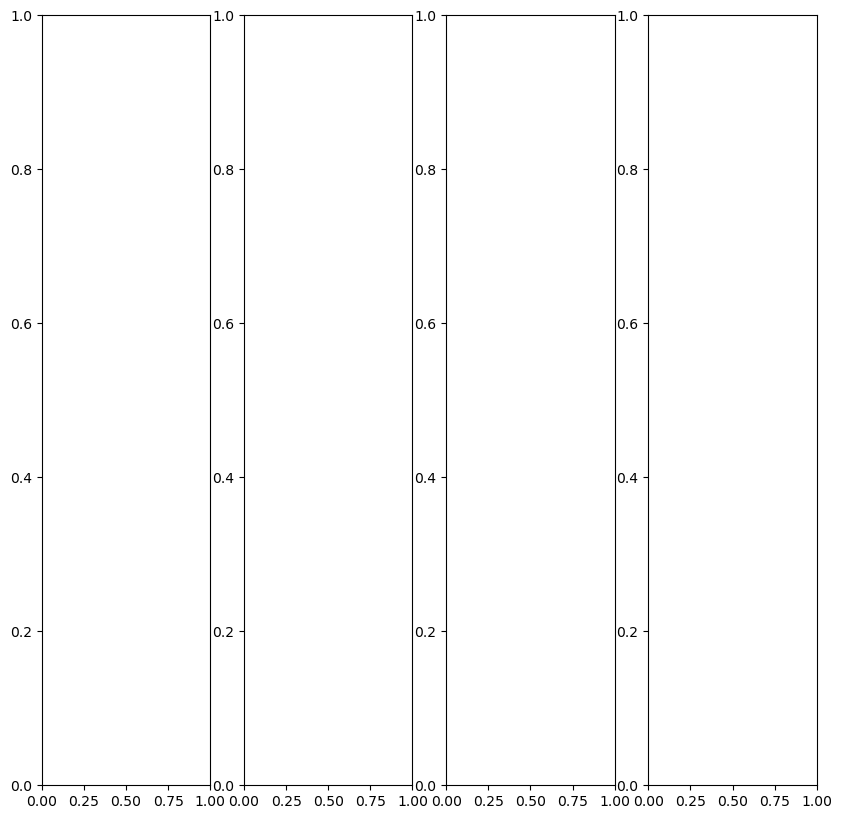

In [44]:
show(next(iter(train_loader)))

In [45]:
imgs = np.concatenate([d[3].numpy() for d in train_loader],axis=0)
imgs = imgs.reshape(imgs.shape[0],-1)
imgs_dim = imgs.shape[1]

IndexError: list index out of range

In [8]:
import pickle
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=ncomps, kernel="poly", gamma=1e-3, fit_inverse_transform=True, alpha=5e-3)
kpca.fit(imgs)

/home/vibujithan/anaconda3/envs/deep/lib/python3.8/site-packages/sklearn/decomposition/_kernel_pca.py:266: LinAlgWarning: Ill-conditioned matrix (rcond=2.93389e-08): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, sym_pos=True, overwrite_a=True)


KernelPCA(alpha=0.005, fit_inverse_transform=True, gamma=0.001, kernel='poly',
          n_components=1500)

## Dimensionality reduction

In [7]:
import pickle
from sklearn.decomposition import KernelPCA

if os.path.exists(kpca_path):
    with open(kpca_path, 'rb') as f:
        kpca = pickle.load(f)
else:
    kpca = KernelPCA(n_components=ncomps, kernel="poly", gamma=1e-3, fit_inverse_transform=True, alpha=5e-3)
    kpca.fit(imgs)
    
    with open(kpca_path, 'wb') as f:
        pickle.dump(kpca, f)

In [8]:
# import pickle
# from sklearn.decomposition import PCA

# if os.path.exists(kpca_path):
#     with open(kpca_path, 'rb') as f:
#         kpca = pickle.load(f)
# else:
#     kpca = PCA(n_components=ncomps)
#     kpca.fit(imgs)
    
#     with open(kpca_path, 'wb') as f:
#         pickle.dump(kpca, f)

In [9]:
sex = np.concatenate([d[0].numpy() for d in train_loader],axis=0)
age = np.concatenate([d[1].numpy() for d in train_loader],axis=0)
bmi = np.concatenate([d[2].numpy() for d in train_loader],axis=0)

In [10]:
from sklearn.preprocessing import StandardScaler

age = np.round(age)
min_age = np.min(age)
age-=min_age

In [11]:
encoded_data = kpca.transform(imgs)

In [12]:
with open(train_path, 'wb') as f:
    pickle.dump({'imgs':imgs, 'sex':sex,'age':age, 'bmi':bmi, 'kpca':kpca,'encoded_data':encoded_data, 'min_age':min_age}, f)

In [13]:
test_dataset = UKBBT1Dataset(test_csv_path, test_img_path, transforms.Compose([ToFloatUKBB(),ToTensor(), CenterCrop(crop_size)]))
test_loader = DataLoader(test_dataset, batch_size=batch_size)

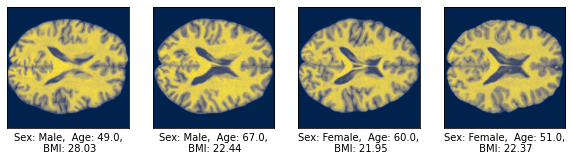

In [14]:
show(next(iter(test_loader)))

In [15]:
test_imgs = np.concatenate([d[3].numpy() for d in test_loader],axis=0)
test_imgs = test_imgs.reshape(test_imgs.shape[0],-1)
test_imgs_dim = test_imgs.shape[1]

In [16]:
sample_imgs = test_imgs[:5,:]
t = kpca.transform(sample_imgs)
X_recon = kpca.inverse_transform(t)

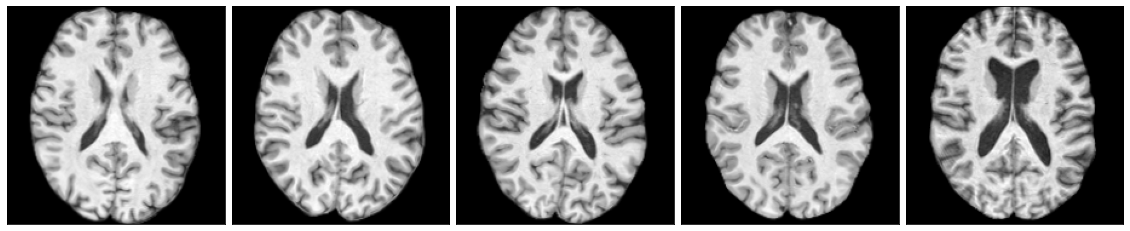

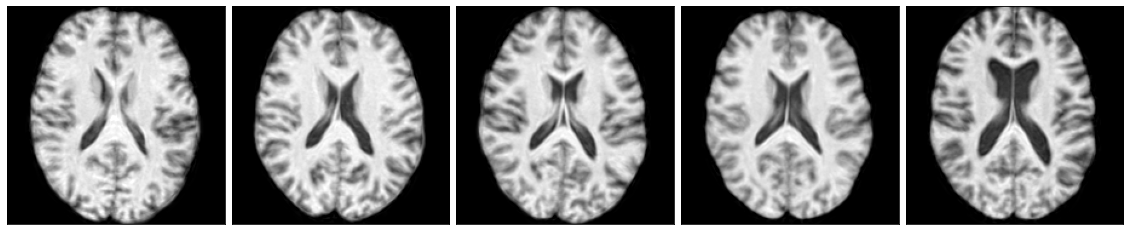

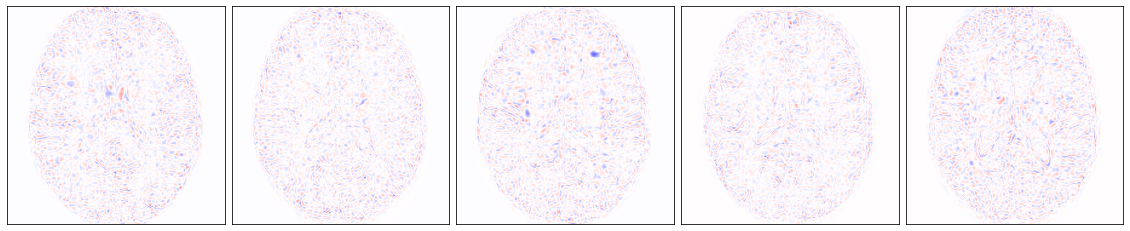

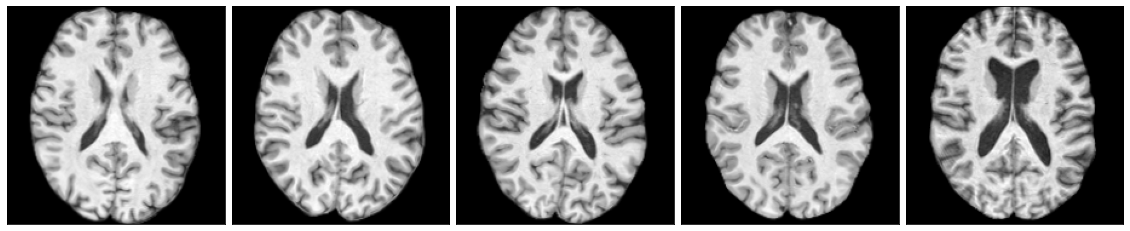

In [17]:
import utils.visualize as vis

plt.rcParams["figure.figsize"] = 20,5

diff = sample_imgs - X_recon
rr = X_recon + diff
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in sample_imgs], clim=(0,1), cols=5)
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in X_recon], clim=(0,1), cols=5)
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in diff], clim=(-1,1), cols=5, cmap='seismic')
fig = vis.img_grid([np.rot90(d.reshape(crop_size,crop_size)) for d in rr], clim=(0,1), cols=5)

In [18]:
sex = np.concatenate([d[0].numpy() for d in test_loader],axis=0)
age = np.concatenate([d[1].numpy() for d in test_loader],axis=0)
bmi = np.concatenate([d[2].numpy() for d in test_loader],axis=0)

In [19]:
from sklearn.preprocessing import StandardScaler

age = np.round(age)
age-=min_age

encoded_data = kpca.transform(test_imgs)

In [20]:
with open(test_path, 'wb') as f:
    pickle.dump({'imgs':test_imgs, 'sex':sex,'age':age, 'bmi':bmi, 'kpca':kpca,'encoded_data':encoded_data, 'min_age':min_age}, f)